In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table
from dipy.sims.voxel import multi_tensor
import dipy.reconst.dti as dti
import dipy.reconst.dki as dki

from dipy.sims.voxel import (multi_tensor, _add_gaussian, _add_rician,
                             _add_rayleigh)

from pca_utils import (rfiw_phantom, mp_distribution, fiber_segments_phantom)

def localpca(DWI, psize, nep):
    # nep number of elements preserved
    m = (2*psize + 1) ** 3
    n = DWI.shape[3]
    DWIden = np.zeros(DWI.shape)
    for k in range(psize, DWI.shape[2] - psize):
        for j in range(psize, DWI.shape[1] - psize):
            for i in range(psize, DWI.shape[0] - psize):
                X = DWI[i - psize: i + psize + 1, j - psize: j + psize + 1,
                        k - psize: k + psize + 1, :]
                X = X.reshape(m, n)
                M = np.mean(X, axis=0)
                X = X - M
                [L, W] = np.linalg.eigh(np.dot(X.T, X)/m)
                Y = X.dot(W[:, -nep:])
                X = Y.dot(W[:, -nep:].T)
                X = X + M
                X = X.reshape(2*psize + 1, 2*psize + 1, 2*psize + 1, n)
                DWIden[i, j, k, :] = X[psize, psize, psize]
    return DWIden

def evaluate_directions(directions, gtdirections):
    angle = np.zeros(directions.shape[0:3])
    for i in range(directions.shape[0]):
        for j in range(directions.shape[1]):
            for k in range(directions.shape[0]):
                v1 = directions[i, j, k]
                vr = gtdirections[i, j, k]
                angle[i, j, k] = np.arccos(np.abs(v1.dot(vr.T))) * 180.0 / np.pi
    p1, p2, p3 = np.percentile(angle, [25 , 50, 75])
    return p2, p2 - p1, p3 - p2

def evaluate_metric(m, gtm):
    err = m - gtm
    p1, p2, p3 = np.percentile(err, [25, 50, 75])
    return p2, p2 - p1, p3 - p2

In [3]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 8 diffusion-weighted directions for first shell
n_pts = 8
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions8 = hsph_updated.vertices  # directions for each shell

# Sample 30 diffusion-weighted directions for second shell
n_pts = 30
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions30 = hsph_updated.vertices  # directions for each shell

# Sample 60 diffusion-weighted directions for second shell
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 50000)
directions60 = hsph_updated.vertices  # directions for each shell

# Create full dataset parameters
bvals = np.hstack((np.zeros(6), 300 * np.ones(8),
                   1000 * np.ones(30), 2000 * np.ones(60)))
bvecs = np.vstack((np.zeros((6, 3)), directions8, directions30, directions60))
gtab = gradient_table(bvals, bvecs)

In [4]:
fsigma = 20.0
dtiM = dti.TensorModel(gtab)
dkiM = dki.DiffusionKurtosisModel(gtab)

In [5]:
# initialize
fsigmas = np.array([40.0, 30.0, 20.0, 10.0])
neps = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 25, 30, 40, 50, 70, 90, 104])
dir1 = np.zeros((neps.size, fsigmas.size))
dir2 = np.zeros(dir1.shape)
dir3 = np.zeros(dir1.shape)
fa1 = np.zeros(dir1.shape)
fa2 = np.zeros(dir1.shape)
fa3 = np.zeros(dir1.shape)
md1 = np.zeros(dir1.shape)
md2 = np.zeros(dir1.shape)
md3 = np.zeros(dir1.shape)
mk1 = np.zeros(dir1.shape)
mk2 = np.zeros(dir1.shape)
mk3 = np.zeros(dir1.shape)

snr = 15
sigma = 50.0 /snr

for p in range(4):
    # ground truth is now the average of rician noise data
    Phantom = fiber_segments_phantom(gtab, fsigmas[p])

    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_gt = _add_rician(Phantom.copy(), n1, n2)

    for rep in range(9):
        # add noise
        n1 = np.random.normal(0, sigma, size=Phantom.shape)
        n2 = np.random.normal(0, sigma, size=Phantom.shape)
        Phantom_gt = Phantom_gt + _add_rician(Phantom.copy(), n1, n2)
    Phantom_gt = Phantom_gt / 10
    
    dtiFgt = dtiM.fit(Phantom_gt)
    FAgt = dtiFgt.fa
    MDgt = dtiFgt.md 
    directionsgt = dtiFgt.directions
    dkiFgt = dkiM.fit(Phantom_gt)
    MKgt = dkiFgt.mk()

    # add noise
    n1 = np.random.normal(0, sigma, size=Phantom.shape)
    n2 = np.random.normal(0, sigma, size=Phantom.shape)
    Phantom_noise = _add_rician(Phantom.copy(), n1, n2)

    # denoise and compare
    for r in range(neps.size):
        Pden = localpca(Phantom_noise.copy(), 2, neps[r])
        dtiF = dtiM.fit(Pden)
        FA = dtiF.fa
        MD = dtiF.md
        directions = dtiF.directions
        dkiF = dkiM.fit(Pden)
        MK = dkiF.mk()
        p1, p2, p3 = evaluate_directions(directions[2:-2, 2:-2, 2:-2], directionsgt[2:-2, 2:-2, 2:-2])
        dir1[r, p] = p1
        dir2[r, p] = p2
        dir3[r, p] = p3
        p1, p2, p3 = evaluate_metric(FA[2:-2, 2:-2, 2:-2], FAgt[2:-2, 2:-2, 2:-2])
        fa1[r, p] = p1
        fa2[r, p] = p2
        fa3[r, p] = p3
        p1, p2, p3 = evaluate_metric(MD[2:-2, 2:-2, 2:-2], MDgt[2:-2, 2:-2, 2:-2])
        md1[r, p] = p1
        md2[r, p] = p2
        md3[r, p] = p3
        p1, p2, p3 = evaluate_metric(MK[2:-2, 2:-2, 2:-2], MKgt[2:-2, 2:-2, 2:-2])
        mk1[r, p] = p1
        mk2[r, p] = p2
        mk3[r, p] = p3
        print r

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


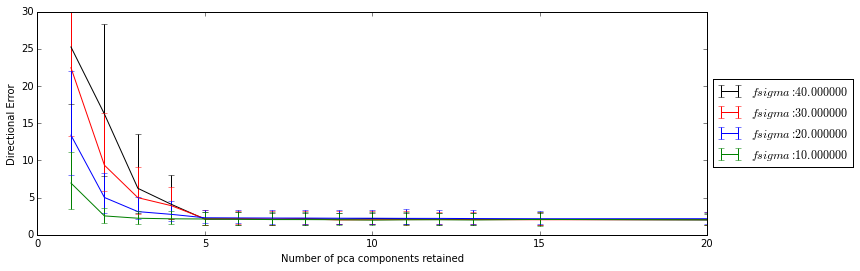

In [6]:
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    plt.errorbar(neps, dir1[:, p], yerr=[dir2[:, p], dir3[:, p]],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.axis([0, 20, 0, 30])
plt.xlabel('Number of pca components retained')
plt.ylabel('Directional Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig = matplotlib.pyplot.gcf()
fig.set_figwidth(12)
plt.show()

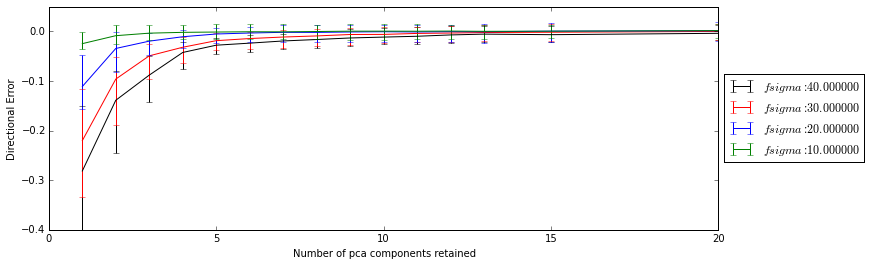

In [7]:
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    plt.errorbar(neps, fa1[:, p], yerr=[fa2[:, p], fa3[:, p]],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.axis([0, 20, -0.4, 0.05])
plt.xlabel('Number of pca components retained')
plt.ylabel('Directional Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig = matplotlib.pyplot.gcf()
fig.set_figwidth(12)
plt.show()

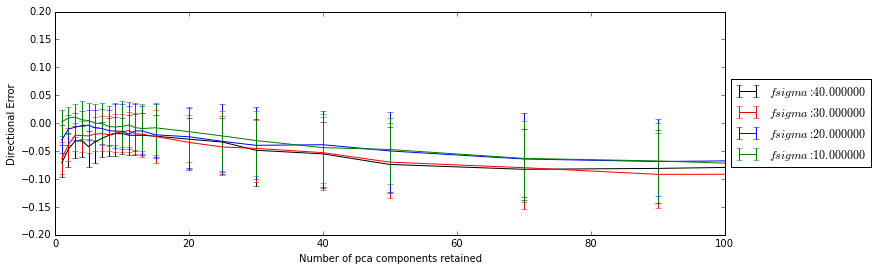

In [8]:
colors = {0: 'black', 1: 'r', 2: 'b', 3: 'g'}
for p in range(4):
    plt.errorbar(neps, mk1[:, p], yerr=[mk2[:, p], mk3[:, p]],
                 color=colors[p], ecolor=colors[p],
                 label='$f sigma: %f$' % fsigmas[p])
plt.axis([0, 100, -0.2, 0.2])
plt.xlabel('Number of pca components retained')
plt.ylabel('Directional Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig = matplotlib.pyplot.gcf()
fig.set_figwidth(12)
plt.show()